In [9]:
import os, random
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.rcParams["xtick.direction"] = 'in'
plt.rcParams["ytick.direction"] = 'in'
params = {
   'axes.labelsize': 16,
   'font.size': 16,
   'legend.fontsize': 14,
   'xtick.labelsize': 16,
   'ytick.labelsize': 16,
   'text.usetex': False,
   'figure.figsize': [4, 2.5],
   'mathtext.fontset': 'stix',
   'font.family': 'STIXGeneral'
   }
plt.rcParams.update(params)
from tqdm import tqdm
import model_architecture 
TRN_CELL_IDS = ['G1', 'V5', 'W4', 'W5', 'W8', 'W9']
TEST_CELL_IDS = ['V4', 'W10']

### Degradation Loss Profile

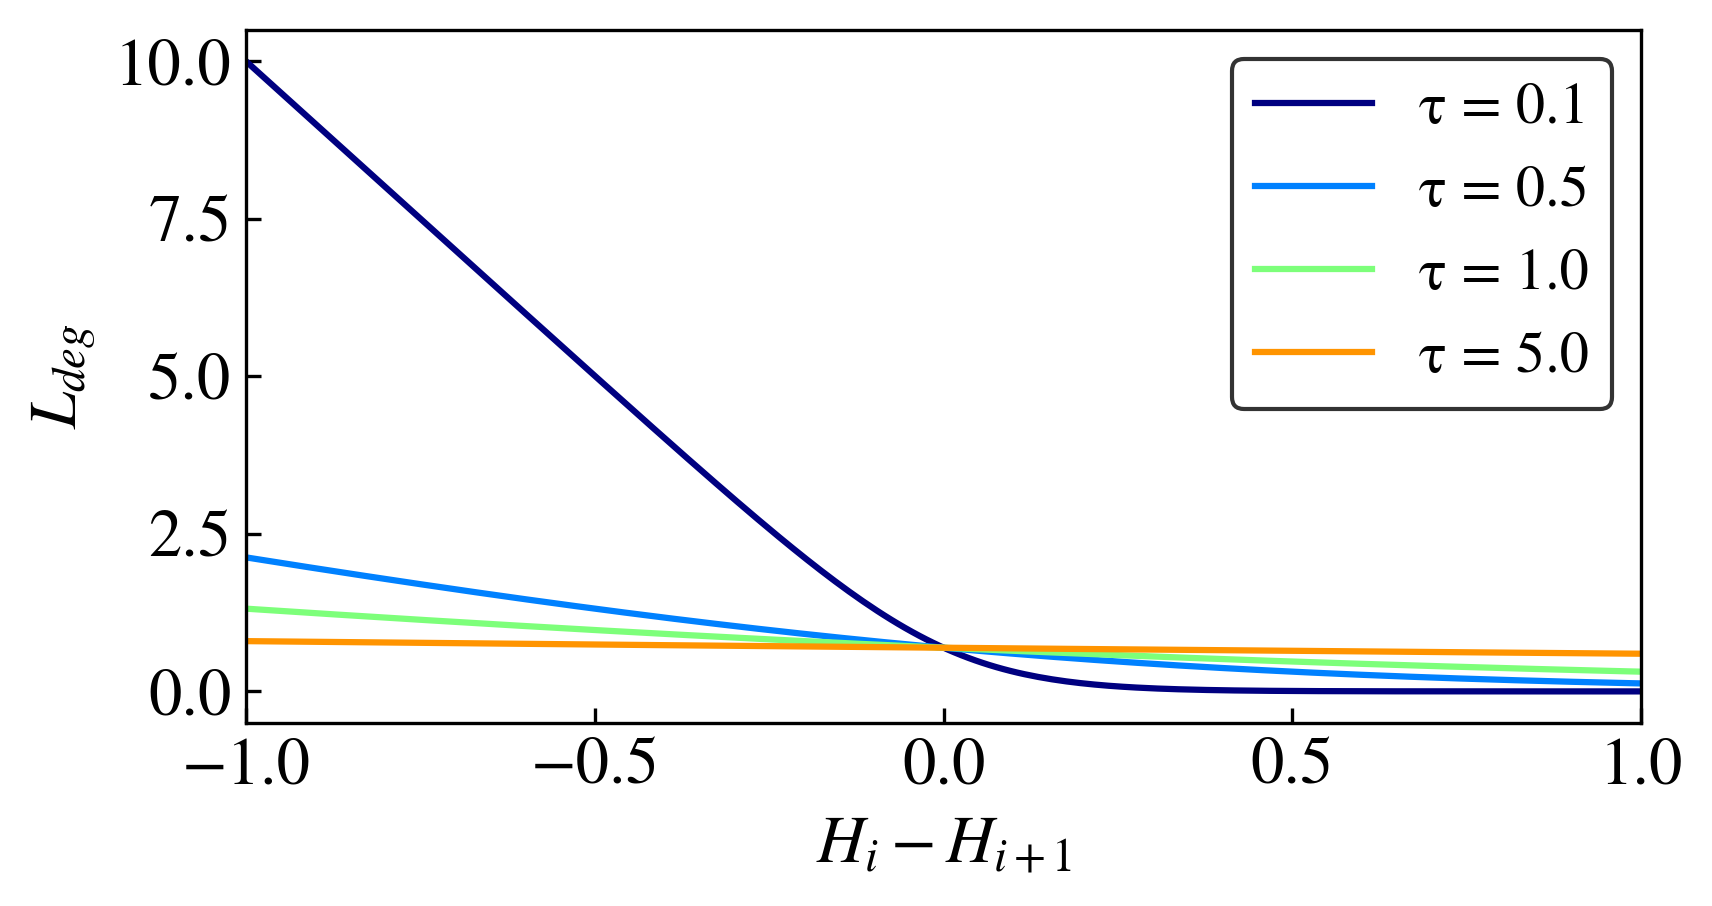

In [2]:
x = np.linspace(-1, 1, 200)
tau_list = [0.1, 0.5, 1, 5]
cmap = plt.get_cmap('jet')
fig, ax = plt.subplots(figsize=(6, 3))
for i, tau in enumerate(tau_list):
    d = np.exp(x/tau)
    dce = -np.log(d/(d+1))
    plt.plot(x, dce, c=cmap(i/len(tau_list)), label='\u03C4 = %.1f'%(tau))
plt.xlim([-1, 1])
plt.ylabel('$L_{deg}$')
plt.xlabel('$H_{i}-H_{i+1}$')
frame = plt.legend().get_frame()
frame.set_edgecolor('0')
plt.savefig('loss.pdf', bbox_inches='tight')
plt.show()
plt.close()

### Stanford Dataset data distribution

In [ ]:
import pandas as pd
Cell_ids = ['G1', 'V5', 'W4', 'W5', 'W8', 'W9', 'V4', 'W10']

def get_temperature_from_excel():
    for cell in Cell_ids:
        avg_temp_list = []
        for i in tqdm(range(8)):
            path = 'diagnostic_tests/Diag_%d/Capacity_test/INR21700_M50T_T23_Aging_0_05C_%s.xlsx'%(i+1, cell)
            if not os.path.isfile(path):
                break
            df = pd.read_excel(path, sheet_name=2)
            temper = df["Aux_Temperature(¡æ)_1"].to_numpy()
            if temper.mean == 0:
                continue
            avg_temp_list.append(temper)
        np.save(f'temperature/{cell}_diag_avg_temp.npy', np.hstack(avg_temp_list))

get_temperature_from_excel()

# plot the temperature
# cm = plt.colormaps['tab10']
# fig, ax = plt.subplots(figsize=(6, 6))

# for i, cell in enumerate(Cell_ids):
#     temper = np.load('temperature/%s_diag_avg_temp.npy'%cell)
#     cycle = np.arange(len(temper))+1
#     abnor_pos = np.where(temper==0)[0]
#     cycle = np.delete(cycle, abnor_pos)
#     temper = np.delete(temper, abnor_pos)
#     plt.plot(cycle, temper, marker='o', label=cell, color=cm(i/7), ls='--')
# plt.xlabel('Diagnostic Tests')
# plt.ylabel('Average Temperature (°C)')
# plt.legend()
# plt.show()
# plt.close()

### Load model and data

In [11]:
def load_Stanford_filtered_full_data(load_path='filtered_info_vi', train=True):
    """
    load detrended data, and all sampled patches are included
    
    """
    cell_ids = TRN_CELL_IDS if train else TEST_CELL_IDS
    v_i_info = []
    for cell in tqdm(cell_ids, desc='load dataset'):
        files = sorted(os.listdir(load_path+'/'+cell))
        v_t_list = []
        for f in files:
            v_t = np.load(load_path+'/'+cell+'/'+f)
            v_t_list.append(v_t)
        v_i_info.append(np.concatenate(v_t_list, axis=0))
    return v_i_info 


trn_data = load_Stanford_filtered_full_data()
test_data = load_Stanford_filtered_full_data(train=False)

# mean and standard deviation of voltage and current
m, s = [0, -0.55], [0.033, 1.1] 

# normalize
for d in trn_data: 
    for j in range(2): 
        d[:, j, :] = (d[:, j, :]-m[j])/s[j]
for d in test_data:
    for j in range(2):
        d[:, j, :] = (d[:, j, :]-m[j])/s[j]

# load model
model = torch.load('checkpoints/DSSL_c128_d4.pt')

load dataset: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


### Plot valiation set results

load reference data: 100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


(1, 40, 2, 3600)


inference W10: 100%|██████████| 20/20 [01:31<00:00,  4.56s/it]


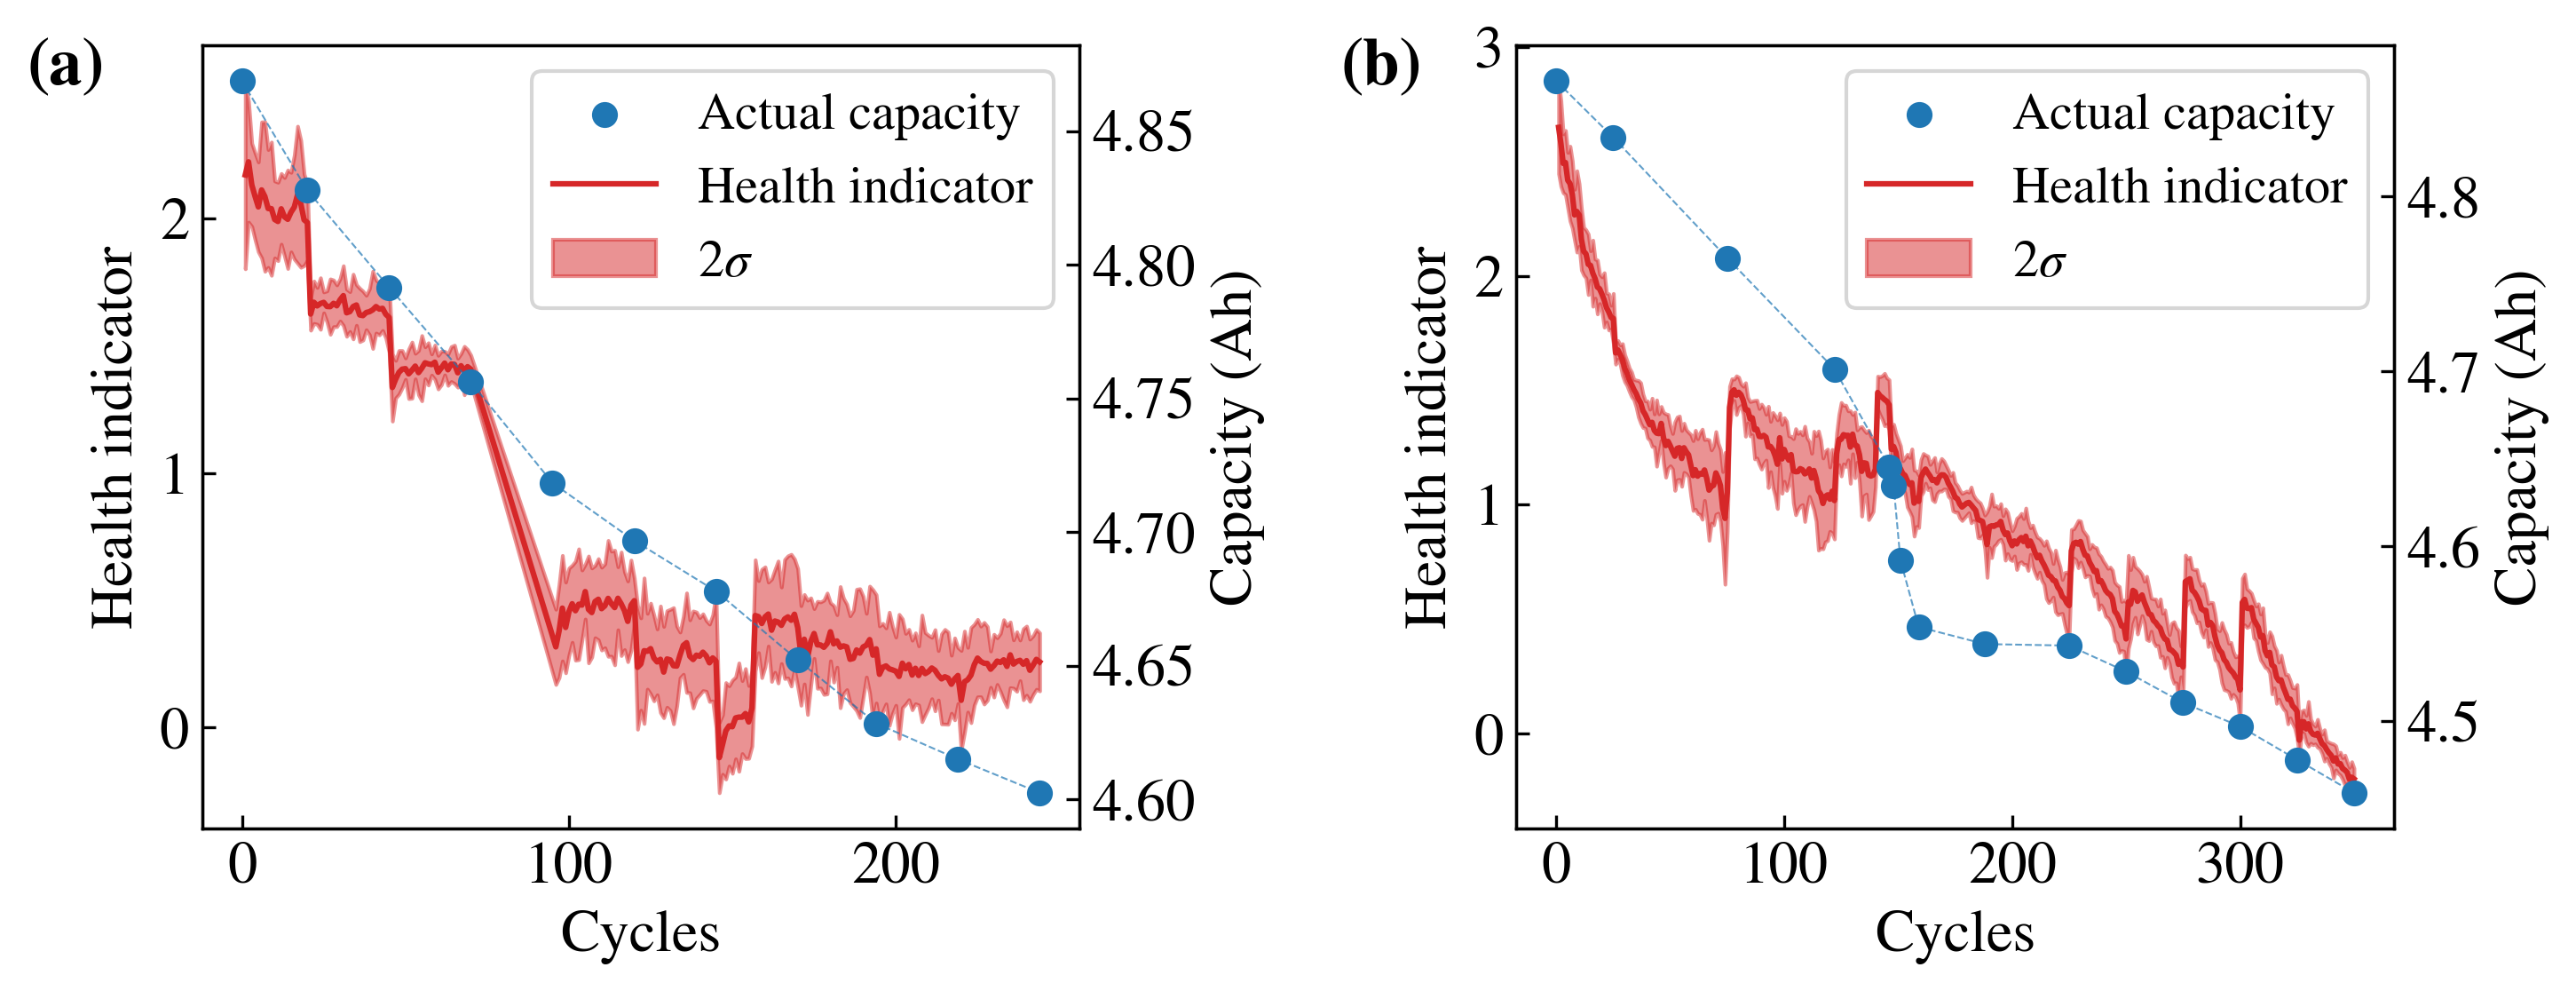

In [12]:
# load training data as referece 
dataset_id = [0, 3, 4, 5]  # 'G1', 'W5', 'W8', 'W9'
database = []
for id in tqdm(dataset_id, desc='load reference data'):
    sample = trn_data[id].copy().reshape(-1, 20, 2, 3600)
    c_id = np.linspace(0, len(sample)-1, 10).astype(int) # get 10 cycles
    database.append(np.expand_dims(sample[c_id, random.randint(0, 19), :, :], axis=0)) # select the random patch
database = np.concatenate(database, axis=1)
print(database.shape)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
for i in range(2):
    test_id = TEST_CELL_IDS[i]
    test_cell = test_data[i].copy().reshape(-1, 20, 2, 3600) 
    cycle_id = os.listdir('filtered_info_vi/%s'%test_id)
    cycle_id = np.sort(np.array([int(f[-7:-4].lstrip('0')) for f in cycle_id]))
    h_value_distri = []

    # 取20種採樣結果計算分布
    for j in tqdm(range(20), desc=f'inference {test_id}'): 
        test_cell_sample = test_cell[:, j]
        h_list = []
        with torch.no_grad():
            for cycle in test_cell_sample: # 每個cycle獨立出來計算健康度
                cycle = cycle.reshape(1, 1, 2, 3600)
                input_arr = torch.tensor(np.concatenate([database, cycle], axis=1))
                h_list.append(model(input_arr.cuda().float()).detach().cpu().numpy()[0, -1])
        h_value_distri.append(np.array(h_list).reshape(-1, 1))
        
    h_value_distri = np.concatenate(h_value_distri, axis=1) # 合併20種採樣結果
    h_mean, h_std = np.mean(h_value_distri, axis=1), np.std(h_value_distri, axis=1)
    ax1 = ax[i]
    ax1.set_xlabel('Cycles')
    ax1.plot(cycle_id, h_mean, c='tab:red', label='Health indicator')
    ax1.fill_between(cycle_id, h_mean+2*h_std, h_mean-2*h_std, color='tab:red', alpha=.5, label='2$\sigma$')
    ax1.set_ylabel('Health indicator')
    real_cap = np.load('capacity_each_cell/%s_capacity.npy'%test_id)
    ax2 = ax1.twinx()
    ax2.scatter(real_cap[0, :], real_cap[1, :], c='tab:blue', label='Actual capacity')  
    ax2.plot(real_cap[0, :], real_cap[1, :], c='tab:blue', alpha=0.7, lw=0.5, ls='--')  
    ax2.set_ylabel('Capacity (Ah)')
    # ax2.set_yticks((4.6, 4.7, 4.8, 4.9))
    lines, labels = ax2.get_legend_handles_labels()
    lines2, labels2 = ax1.get_legend_handles_labels()
    ax1.legend(lines+lines2, labels+labels2, loc=0)

ax[0].text(-.2, .95, '(a)', transform=ax[0].transAxes, fontsize=18, weight='bold')
ax[1].text(-.2, .95, '(b)', transform=ax[1].transAxes, fontsize=18, weight='bold')
fig.tight_layout()
plt.savefig('paper_figs/testing_cells.pdf')
plt.show()
plt.close()

### Plot results and other LIB properties for analysis

(799586,)
(373428,)
(699946,)
(718549,)
(710974,)
(711181,)
(816454,)
(711082,)


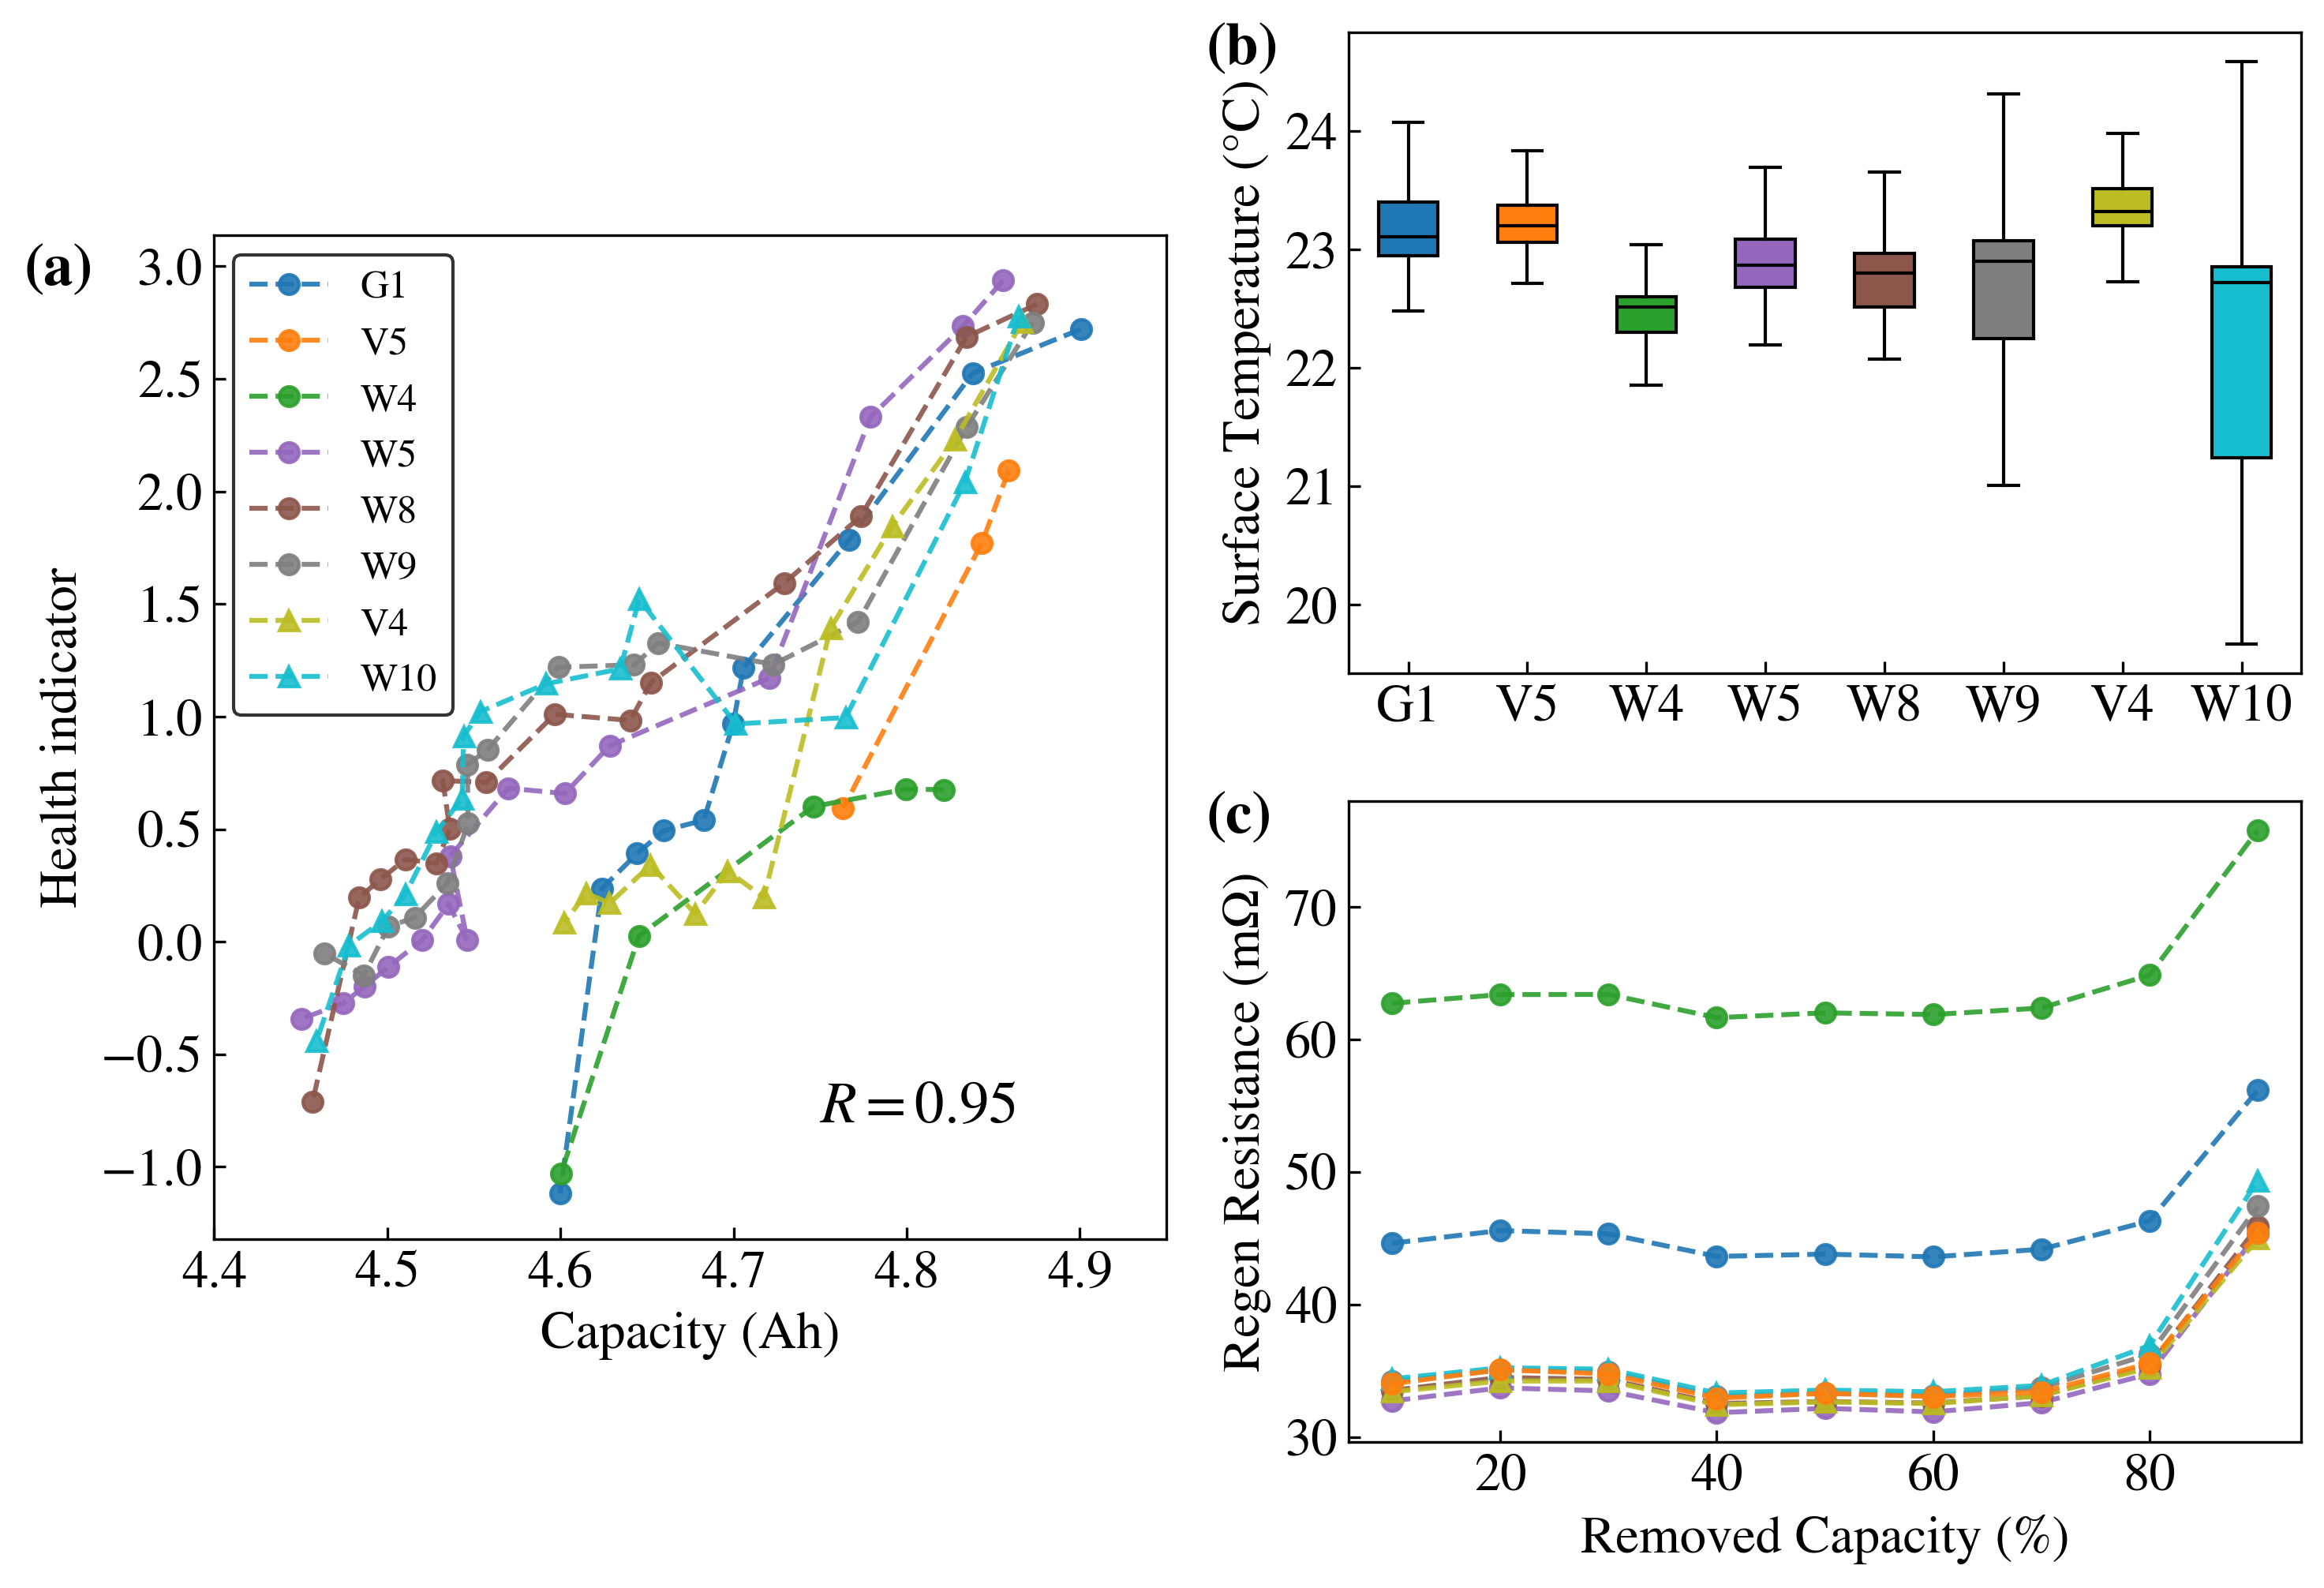

In [36]:
from scipy.io import loadmat
Cell_ids = ['G1', 'V5', 'W4', 'W5', 'W8', 'W9', 'V4', 'W10']

# load model prediction
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))
gs = ax[0, 0].get_gridspec()
for a in ax[:, 0]:
    a.remove()
axbig = fig.add_subplot(gs[:, 0])
cm = plt.colormaps['tab10']

r_score = 0
for i, cell_id in enumerate(Cell_ids):
    real_soh, est_h = np.load(f'output_npy/{cell_id}.npy')
    marker = 'o' if i<6 else '^'
    r_score += np.corrcoef(real_soh, est_h)[0, 1]
    axbig.plot(real_soh, est_h, color=cm(i/7), label=cell_id, marker=marker, alpha=.9, markersize=6, ls='--')
axbig.set_xlabel('Capacity (Ah)')
axbig.set_ylabel('Health indicator')
axbig.set_xlim([4.4, 4.95])
axbig.text(4.75, -0.8, '$R=%.2f$'%(r_score/8), fontsize=18)
axbig.set_aspect(0.13)

# for boxplt
temper_list = []
for i, cell in enumerate(Cell_ids):
    temper = np.load('temperature/%s_diag_avg_temp.npy'%cell)
    print(temper.shape)
    abnor_pos = np.where(temper==0)[0]
    temper = np.delete(temper, abnor_pos)
    temper_list.append(temper)
bplot = ax[0, 1].boxplot(temper_list, tick_labels=Cell_ids, patch_artist=True, showfliers=False)
ax[0, 1].set_ylabel('Surface Temperature (°C)')
for i, box in enumerate(bplot['boxes']):
    box.set(facecolor=cm(i/7))
for median in bplot['medians']:
    median.set_color('black')

frame = axbig.legend(fontsize=12).get_frame()
frame.set_edgecolor('0')

# internal resistance plot
diag_test_id = 2
c_dict = {}
for i, id in enumerate(Cell_ids):
    c_dict[id] = cm(i/7)

hppc_test = loadmat('diagnostic_tests/HPPC_test.mat')
cell_ids = [id[0] for id in hppc_test['col_cell_label'][0]]

for i, id in enumerate(cell_ids):
    if id in Cell_ids and not np.isnan(hppc_test['vcell'][diag_test_id, i][0]):
        V = hppc_test['vcell'][diag_test_id, i]
        I = hppc_test['curr'][diag_test_id, i]
        charge_start = np.where(np.diff((I>1).astype(int).flatten())==1)[0]
        charge_end = np.where(np.diff((I>1).astype(int).flatten())==-1)[0]
        charge_i = I.max()

        IR_list = []
        for start, end in zip(charge_start, charge_end):
            dV = np.abs(V[start]-V[end])
            IR_list.append(dV/charge_i*1000)

        soc = (np.arange(9)+1)*10
        marker = '^' if id in ['V4','W10'] else 'o'
        ax[1, 1].plot(soc, IR_list, label=id, ls='--', marker=marker, alpha=.9, markersize=6, color=c_dict[id])
        
ax[1, 1].set_ylabel('Regen Resistance (mΩ)')
ax[1, 1].set_xlabel('Removed Capacity (%)')

axbig.text(-.2, .95, '(a)', transform=axbig.transAxes, fontsize=18, weight='bold')
ax[0, 1].text(-.15, .95, '(b)', transform=ax[0, 1].transAxes, fontsize=18, weight='bold')
ax[1, 1].text(-.15, .95, '(c)', transform=ax[1, 1].transAxes, fontsize=18, weight='bold')
# frame = ax[1, 1].legend(fontsize=12, bbox_to_anchor=(1.3, 1)).get_frame()
# frame.set_edgecolor('0')
fig.tight_layout()
plt.savefig('paper_figs/soh_and_temp.pdf')
plt.show()
plt.close()

### Finetuned model for capacity estimation

Training sample number: 58
Testing sample number: 24


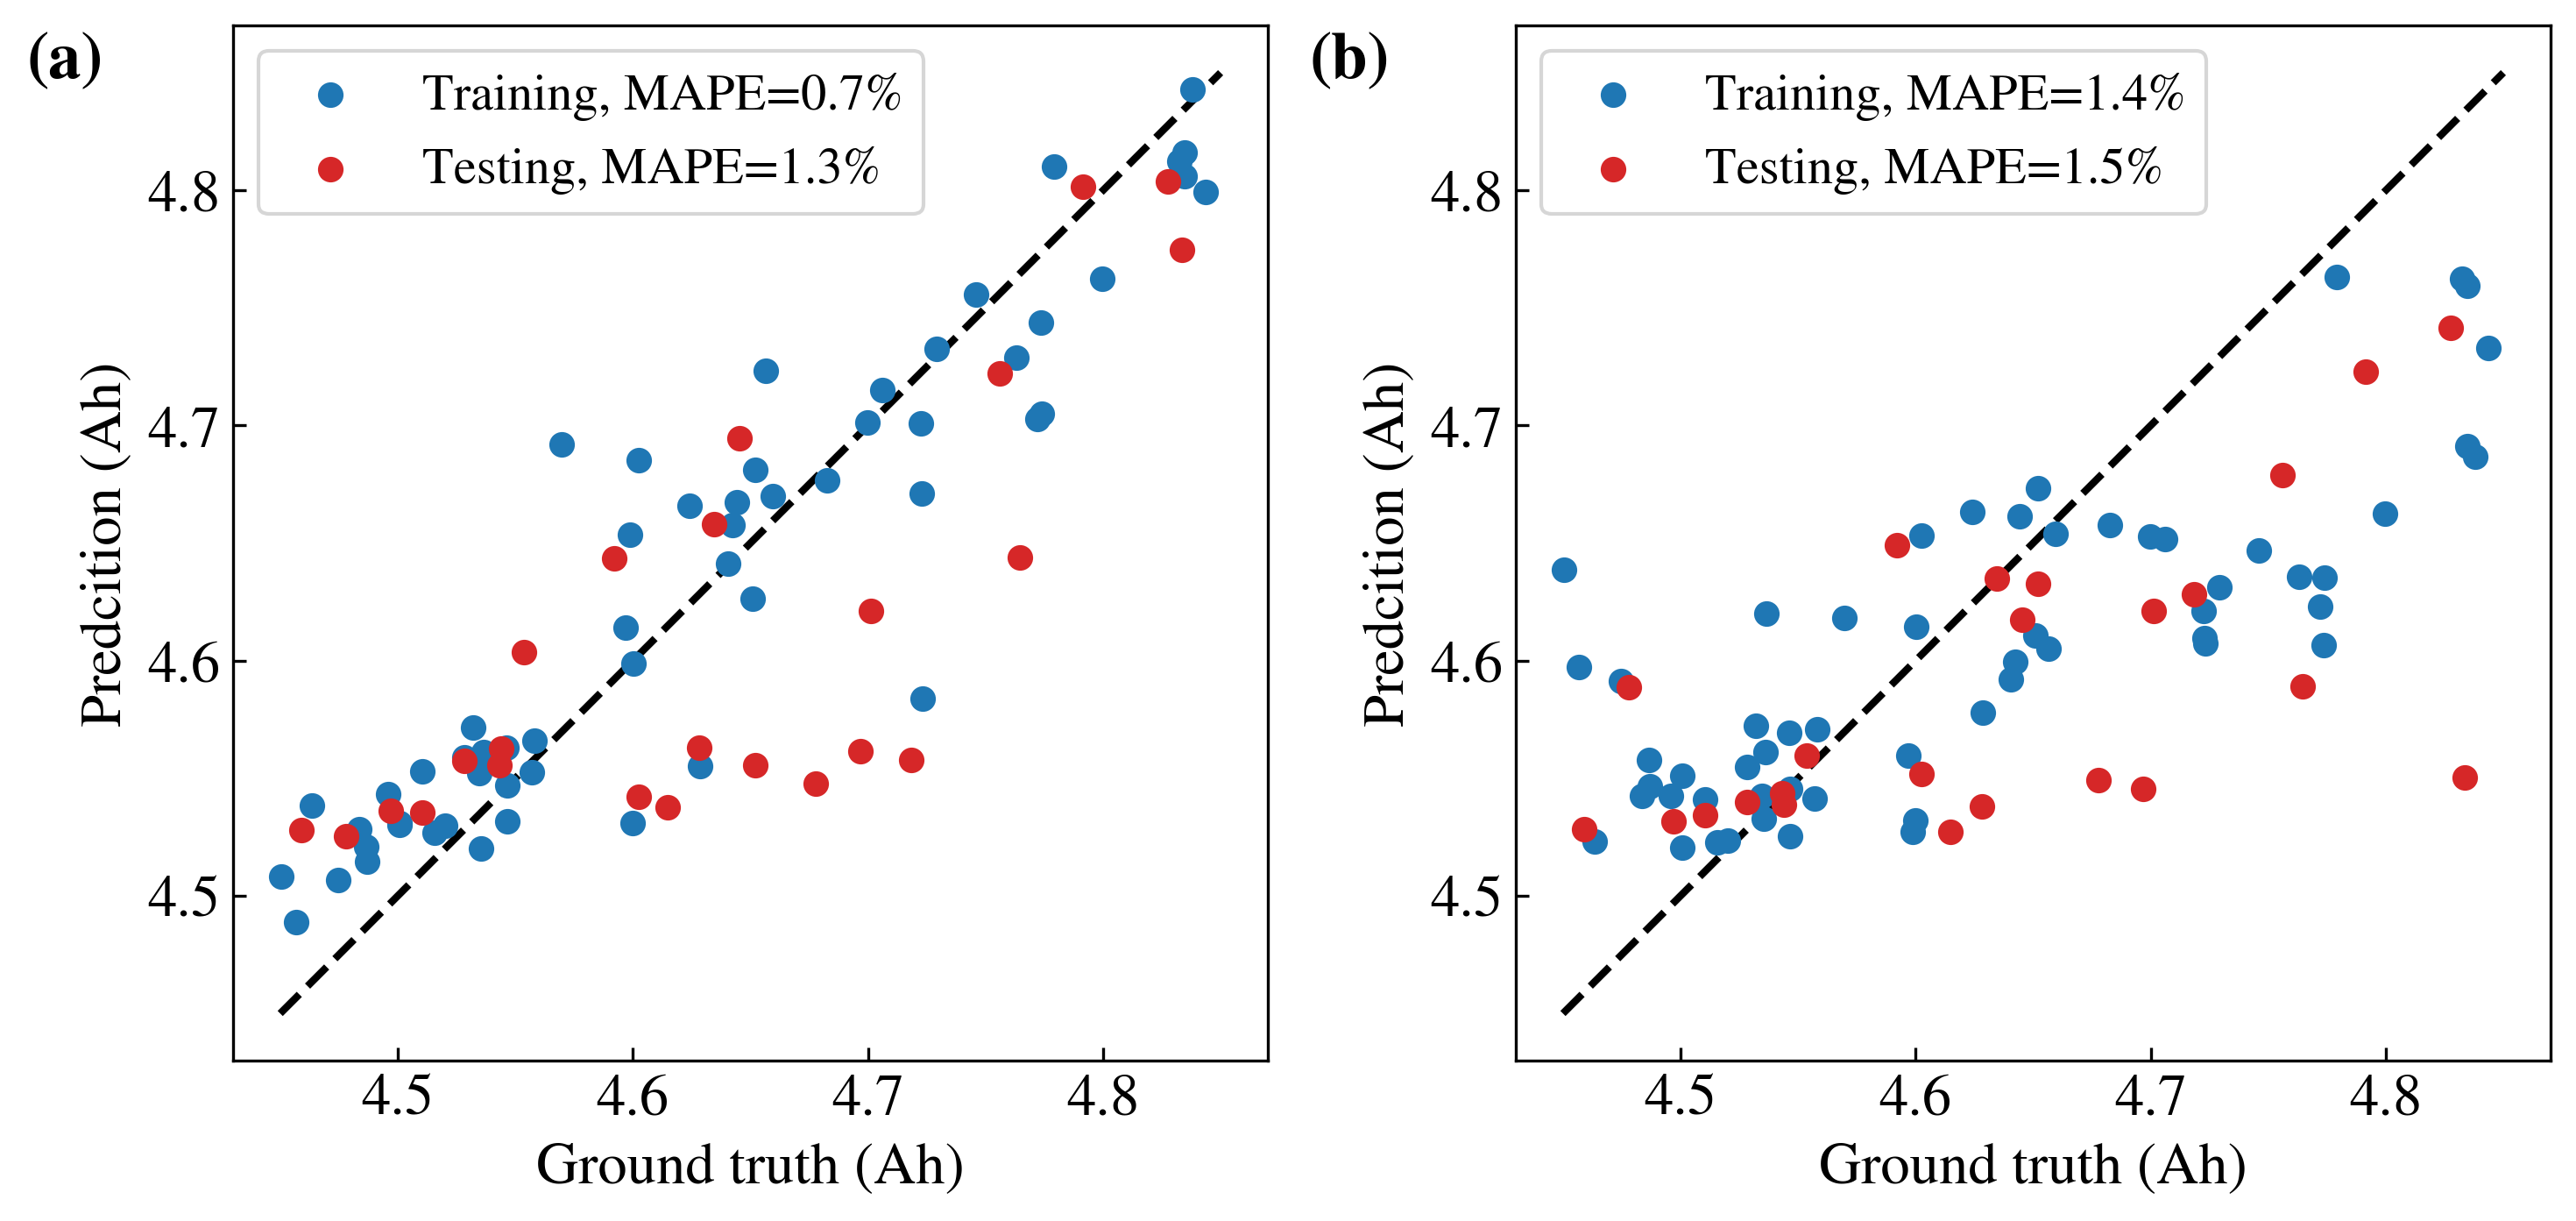

In [46]:
def rmse_and_mape(labels, outputs):
    rmse = np.sqrt(np.mean((outputs-labels)**2))
    mape = np.mean(np.abs(outputs-labels)/labels)
    return rmse, mape

def load_Stanford_capacity_data(train=True):
    def find_nearest(array, value):
        array = np.asarray(array)
        if np.abs(array - value).min()<=10:
            return np.abs(array - value).argmin()
        return False
    load_path = 'filtered_info_vi'
    v_t_return, cap_return = [], []
    cell_ids = TRN_CELL_IDS if train else TEST_CELL_IDS
    for cell in cell_ids:
        files = sorted(os.listdir(load_path+'/'+cell)) # file names
        cycle_id = np.sort(np.array([int(f[-7:-4].lstrip('0')) for f in files])) # extract correspond cycle id
        real_cap = np.load('capacity_each_cell/%s_capacity.npy'%(cell)) # load real capacity
        cycle_with_cap = real_cap[0, :] # cycle id with measured capacity
        v_t_list = []
        cap_list = []
        for i, cycle in enumerate(cycle_with_cap):
            cycle = 1 if cycle == 0 else cycle
            target_cycle = find_nearest(cycle_id, cycle)
            if target_cycle: v_t = np.load(load_path+'/'+cell+'/'+files[target_cycle])
            else: continue
            start = np.random.choice(20, 1)[0]
            v_t_list.append(v_t[start].reshape(1, 2, -1))
            cap_list.append(real_cap[1, i])
        v_t_return.append(np.vstack(v_t_list))
        cap_return.append(np.array(cap_list))
    return v_t_return, cap_return


np.random.seed(4)
model_1 = torch.load('checkpoints/Capacity_Esti_CNN_finetuned.pt')
model_2 = torch.load('checkpoints/Capacity_Esti_CNN_from_scratch.pt')
model_1.eval()
model_2.eval()
trn_f, trn_l = load_Stanford_capacity_data(train=True)
trn_f, trn_l = np.concatenate(trn_f, axis=0), np.concatenate(trn_l, axis=0)
print('Training sample number:', len(trn_f))
m, s = [0, -0.55], [0.033, 1.1]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.patch.set_alpha(0.0)
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')
for i in range(2):
    trn_f[:, i, :] = (trn_f[:, i, :]-m[i])/s[i]
trn_f = np.expand_dims(trn_f, axis=1)
trn_f = torch.tensor(trn_f).cuda().float()
with torch.no_grad():
    outputs_tuned = model_1(trn_f).detach().cpu().numpy().squeeze()
    outputs_base = model_2(trn_f).detach().cpu().numpy().squeeze()
trn_error_finetuned = rmse_and_mape(trn_l, outputs_tuned*0.12+4.64)
trn_error_base = rmse_and_mape(trn_l, outputs_base*0.12+4.64)
ax[0].scatter(trn_l, outputs_tuned*0.12+4.64, c='tab:blue', label=f'Training, MAPE={trn_error_finetuned[1]:.1%}')
ax[1].scatter(trn_l, outputs_base*0.12+4.64, c='tab:blue', label=f'Training, MAPE={trn_error_base[1]:.1%}')

# testing
trn_f, trn_l = load_Stanford_capacity_data(train=False)
trn_f, trn_l = np.concatenate(trn_f, axis=0), np.concatenate(trn_l, axis=0)
print('Testing sample number:', len(trn_f))
for i in range(2):
    trn_f[:, i, :] = (trn_f[:, i, :]-m[i])/s[i]
trn_f = np.expand_dims(trn_f, axis=1)
trn_f = torch.tensor(trn_f).cuda().float()
with torch.no_grad():
    outputs_tuned = model_1(trn_f).detach().cpu().numpy().squeeze()
    outputs_base = model_2(trn_f).detach().cpu().numpy().squeeze()
test_error_finetuned = rmse_and_mape(trn_l, outputs_tuned*0.12+4.64)
test_error_base = rmse_and_mape(trn_l, outputs_base*0.12+4.64)
ax[0].scatter(trn_l, outputs_tuned*0.12+4.64, c='tab:red', label=f'Testing, MAPE={test_error_finetuned[1]:.1%}')
ax[1].scatter(trn_l, outputs_base*0.12+4.64, c='tab:red', label=f'Testing, MAPE={test_error_base[1]:.1%}')
ax[0].plot([4.45, 4.85], [4.45, 4.85], ls='--', c='black', lw=2, zorder=0)
ax[1].plot([4.45, 4.85], [4.45, 4.85], ls='--', c='black', lw=2, zorder=0)
ax[0].set_xlabel('Ground truth (Ah)')
ax[1].set_xlabel('Ground truth (Ah)')
ax[0].set_ylabel('Predcition (Ah)')
ax[1].set_ylabel('Predcition (Ah)')
ax[0].text(-.2, .95, '(a)', transform=ax[0].transAxes, weight='bold', fontsize=18)
ax[1].text(-.2, .95, '(b)', transform=ax[1].transAxes, weight='bold', fontsize=18)
ax[0].legend()
ax[1].legend()
fig.tight_layout()
plt.show()
plt.close()

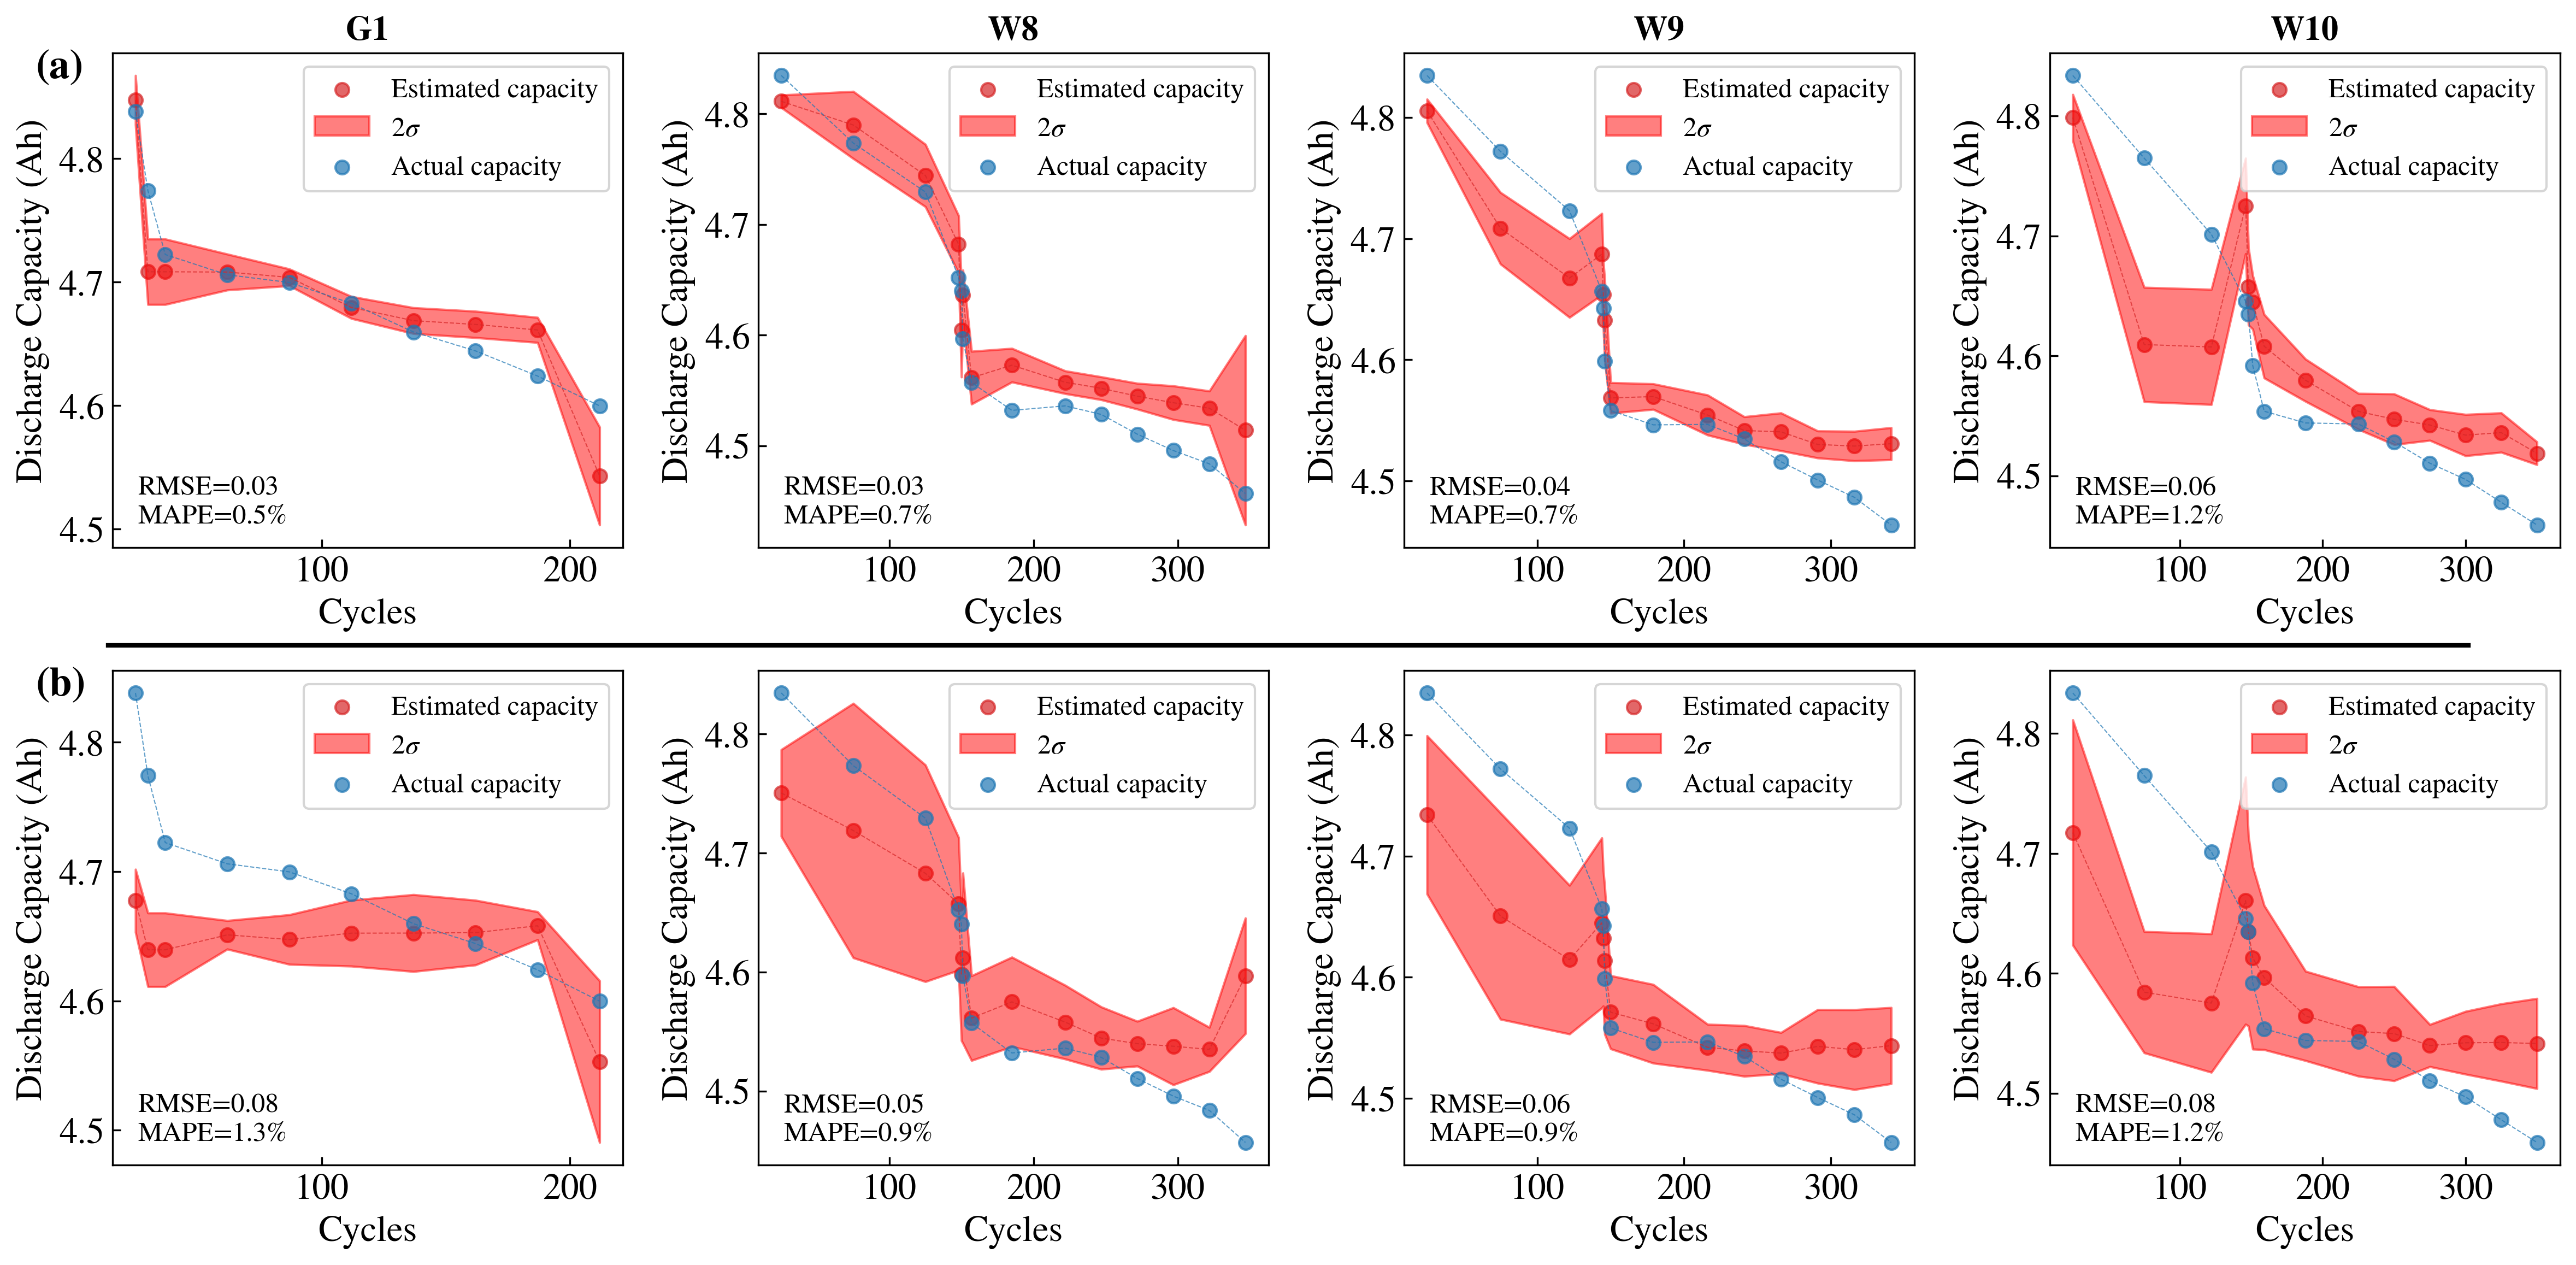

In [83]:
def load_Stanford_capacity_full_data(train=True):
    def find_nearest(array, value):
        array = np.asarray(array)
        if np.abs(array - value).min()<=10:
            return np.abs(array - value).argmin()
        return False
    load_path = 'filtered_info_vi'
    v_t_return, cap_return, cycle_return = [], [], []
    cell_ids = TRN_CELL_IDS if train else TEST_CELL_IDS
    for cell in cell_ids:
        files = sorted(os.listdir(load_path+'/'+cell)) # file names
        cycle_id = np.sort(np.array([int(f[-7:-4].lstrip('0')) for f in files])) # extract correspond cycle id
        real_cap = np.load('capacity_each_cell/%s_capacity.npy'%(cell)) # load real capacity
        cycle_with_cap = real_cap[0, :] # cycle id with measured capacity
        v_t_list, cap_list, cycle_list = [], [], []
        for i, cycle in enumerate(cycle_with_cap):
            cycle = 1 if cycle == 0 else cycle
            target_cycle = find_nearest(cycle_id, cycle)
            if target_cycle: v_t = np.load(load_path+'/'+cell+'/'+files[target_cycle])
            else: continue
            v_t_list.append(np.expand_dims(v_t, axis=0))
            cap_list.append(real_cap[1, i])
            cycle_list.append(real_cap[0, i])
        v_t_return.append(np.vstack(v_t_list))
        cap_return.append(np.array(cap_list))
        cycle_return.append(np.array(cycle_list))
    return v_t_return, cap_return, cycle_return

full_cell_ids = TRN_CELL_IDS+TEST_CELL_IDS
trn_f, trn_l, trn_c = load_Stanford_capacity_full_data(train=True)
test_f, test_l, test_c = load_Stanford_capacity_full_data(train=False)
features, labels, cycles = trn_f+test_f, trn_l+test_l, trn_c+test_c
m, s = [0, -0.55], [0.033, 1.1]

fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(16, 8))

model =torch.load('checkpoints/Capacity_Esti_CNN_finetuned.pt')
model.eval()
fig_count = -1
for i, d in enumerate(features):
    cell_id = full_cell_ids[i]
    if cell_id in ['W4', 'V5', 'W5', 'V4']:
        continue
    fig_count += 1
    real_cap = labels[i]
    real_cycle = cycles[i]
    c_mean, c_std = [], []
    with torch.no_grad():   
        inputs = d
        for j in range(2):
            inputs[:, :, j, :] = (inputs[:, :, j, :]-m[j])/s[j]
        for j in range(inputs.shape[0]):
            input_seq = torch.tensor(inputs[j].reshape(20, 1, 2, 3600))
            capacity = model(input_seq.cuda().float()).detach().cpu().numpy().squeeze()*0.12+4.64
            c_mean.append(capacity.mean())
            c_std.append(capacity.std())
    c_mean, c_std = np.array(c_mean), np.array(c_std)
    rmse, mape = rmse_and_mape(real_cap, c_mean)
    # visualize 
    ax = axs[0, fig_count]
    ax.set_title(f'{cell_id}', weight='bold', fontsize=15)
    ax.set_xlabel('Cycles')
    ax.scatter(real_cycle, c_mean, c='tab:red', alpha=.7, label='Estimated capacity') 
    ax.fill_between(real_cycle, c_mean+2*c_std, c_mean-2*c_std, color='red', alpha=.5, label='$2\sigma$')
    ax.plot(real_cycle, c_mean, c='tab:red', alpha=0.7, lw=0.5, ls='--')
    ax.set_ylabel('Discharge Capacity (Ah)')
    ax.scatter(real_cycle, real_cap, c='tab:blue', alpha=.7, label='Actual capacity')  
    ax.plot(real_cycle, real_cap, c='tab:blue', alpha=0.7, lw=0.5, ls='--')   
    ax.text(0.05, 0.05, f'RMSE={rmse:.1}\nMAPE={mape:.1%}', transform=ax.transAxes, fontsize=12)
    plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
    ax.legend(loc='upper right', fontsize=12)

model =torch.load('checkpoints/Capacity_Esti_CNN_from_scratch.pt')
model.eval()
fig_count = -1
for i, d in enumerate(features):
    cell_id = full_cell_ids[i]
    if cell_id in ['W4', 'V5', 'W5', 'V4']:
        continue
    fig_count += 1
    real_cap = labels[i]
    real_cycle = cycles[i]
    c_mean, c_std = [], []
    with torch.no_grad():   
        inputs = d
        # for j in range(2):
        #     inputs[:, :, j, :] = (inputs[:, :, j, :]-m[j])/s[j]
        for j in range(inputs.shape[0]):
            input_seq = torch.tensor(inputs[j].reshape(20, 1, 2, 3600))
            capacity = model(input_seq.cuda().float()).detach().cpu().numpy().squeeze()*0.12+4.64
            c_mean.append(capacity.mean())
            c_std.append(capacity.std())
    c_mean, c_std = np.array(c_mean), np.array(c_std)
    rmse, mape = rmse_and_mape(real_cap, c_mean)
    # visualize 
    ax = axs[1, fig_count]
    # ax.set_title(f'{cell_id}', weight='bold', fontsize=15)
    ax.set_xlabel('Cycles')
    ax.scatter(real_cycle, c_mean, c='tab:red', alpha=.7, label='Estimated capacity') 
    ax.fill_between(real_cycle, c_mean+2*c_std, c_mean-2*c_std, color='red', alpha=.5, label='$2\sigma$')
    ax.plot(real_cycle, c_mean, c='tab:red', alpha=0.7, lw=0.5, ls='--')
    ax.set_ylabel('Discharge Capacity (Ah)')
    ax.scatter(real_cycle, real_cap, c='tab:blue', alpha=.7, label='Actual capacity')  
    ax.plot(real_cycle, real_cap, c='tab:blue', alpha=0.7, lw=0.5, ls='--')   
    ax.text(0.05, 0.05, f'RMSE={rmse:.1}\nMAPE={mape:.1%}', transform=ax.transAxes, fontsize=12)
    plt.gca().yaxis.set_major_locator(mpl.ticker.MultipleLocator(0.1))
    ax.legend(loc='upper right', fontsize=12)

fig.tight_layout()
line = plt.Line2D((.05,.95),(.49,.49), color="k", linewidth=2)
fig.add_artist(line)
axs[0, 0].text(-.15, .95, '(a)', transform=axs[0, 0].transAxes, weight='bold', fontsize=18)
axs[1, 0].text(-.15, .95, '(b)', transform=axs[1, 0].transAxes, weight='bold', fontsize=18)
plt.savefig('paper_figs/finetuned_result.pdf')
plt.show()
plt.close()